# Singular Value Decomposition
Implement SVD given matrix A, and check its possible applications

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Implement SVD of input matrix $A \in \mathbb{R}^{m \times n}$ at below method. As mentioned in the class, SVD consists of matrices composed of eigenvectors and square root of eigenvalues of $A^TA$ and $AA^T$. Here, non-zero singular values are square roots of the non-zero eigenvalues of $A^TA$ and $AA^T$. Use numpy.linalg.eig to get such values and compare the result with numpy.linalg.svd below.

* Be aware of the sign of eigenvectors! Sign of the eigenvectors of $A^TA$ and $AA^T$ should be coherent(They should match when transformed from one to another). Meaning When left singular vector $u_i$ is driven from $v_i$ by $u_i = Av_i$ (or right singular vector from left singular vector vice versa), the sign between transformed $u_i$ and the original left singular vector acquired by from np.linalg.eig(AA^T) should be the same. If they are different, flipping the sign of either one of them is required.  

* Singular values should be aligned in descending order. 

* Other than using numpy elementary operations(numpy.concatenate, numpy.dot etc.) and np.linalg.eig, please ask if it isn't clear(you should not use numpy.linalg.svd!).

In [2]:
import numpy as np

def SVD(A):
    """
    Compute the Singular Value Decomposition (SVD) of a matrix A.

    Parameters:
    A (numpy.ndarray): Input matrix of shape (h, w).

    Returns:
    U (numpy.ndarray): Left singular vectors of shape (h, h).
    Sig (numpy.ndarray): Singular values of shape (min(h, w), 1).
    V (numpy.ndarray): Right singular vectors of shape (w, w).
    """
    A = A.astype(np.float32)
    h, w = A.shape # get the dimension of A

    # Calculate U
    AAT = np.dot(A, A.T)
    eigenValues_U, U = np.linalg.eig(AAT)
    sorted_idx = np.flip(np.argsort(eigenValues_U)) # sorting the eigenvalue in descending order
    U = U[:,sorted_idx]
    
    
    # Calculate V
    ATA = np.dot(A.T, A)
    eigenValues_V, V = np.linalg.eig(ATA)
    sorted_idx = np.flip(np.argsort(eigenValues_V))
    V = V[:,sorted_idx]
    eigenValues_V = eigenValues_V[sorted_idx] # I intended to build sigma matrix by using the eigen value of V(that is same to that of U.)

    # Calculate the singular values (Sig)
    Sig = np.sqrt(eigenValues_V) # I believe that the eigenvalue of V is always positive, which is derived from the linear algebra
    
    # Ensure proper signs in U and V
    for i in range(min(w, h)):
        if np.sign(np.dot(A,V[:,i])[0]) != np.sign(Sig[i]*U[:,i][0]): # if the sign is different
            V[:, i] = -V[:, i] # change the sign
    
    # Sort singular values in descending order
    return U, Sig, V.T


compare results with innate numpy method (check out for sign of column vectors in $U,V$)

In [3]:
# check L2 norm
def check_error(a:np.array, svd:SVD): 
  u,s,v = np.linalg.svd(a)
  v = v.T
  u_impl, s_impl, v_impl = SVD(a)
  v_impl = v_impl.T
  H, W = a.shape
  error = 0.
  for h in range(H):
    if np.sign(u[:,h][0]) != np.sign(u_impl[:,h][0]):
      error += np.linalg.norm(u[:,h][0]+u_impl[:,h][0]) 
    else:
      error += np.linalg.norm(u[:,h][0]-u_impl[:,h][0])
  for w in range(W):
    if np.sign(v[:,w][0]) != np.sign(v_impl[:,w][0]):
      error += np.linalg.norm(v[:,w][0]+v_impl[:,w][0])
    else:
      error += np.linalg.norm(v[:,w][0]-v_impl[:,w][0])
  error += np.linalg.norm(s-s_impl)
  return error

# 1. Orthogonal Procrustes analysis

Orthogonal procrustes analysis is finding a $3 \times 3$ orthogonal matrix $\Omega^*$ that satiesfies  
$$ \Omega^* = \underset{\Omega \in \mathbb{R}^{3 \times 3}}{\text{argmin}}  \|A\Omega  - B\| $$
A and B can be random matrices but here, we will set them as pointclouds($A, B \in \mathbb{R}^{n \times 3}$). Then the problem would be fitting input pointcloud $A$ into target $B$ via transformation $\Omega$. Solving above with SVD will give you the solution. 

In [4]:
import trimesh

## Visualize input and target data

We are going to fit red points into blue points. Check the points are not aligned. You can swibble it around with cursor.

In [5]:
# choose the directory where you put your input cup pointcloud file
input_path = "./input.ply" 
target_path = "./target.ply" 
input_pcd = trimesh.load(input_path)
target_pcd = trimesh.load(target_path)
scene = trimesh.Scene([input_pcd, target_pcd])
scene.show()

## Find transformation

* Note that you should use your implementation of SVD to find below transformations
* Don't worry even if they are not perfectly aligned. We will just check tendency of two separate pointclouds

In [6]:
# find optimal transformation from input toward target
input_pts = np.array(input_pcd.vertices).T # 3xn array
# print(input_pts.shape)
target_pts = np.array(target_pcd.vertices).T # 3xn array
result_pts = None # should be nx3 array
########################################
#------To Do : Fill here---------------#
########################################

# Please check the last section of report to check the mathematical background of the following codes

targetMat = np.dot(target_pts,input_pts.T) # 3 x 3
U,Sig,V = SVD(targetMat)
Omega = np.dot(U,V.T) # 3 x 3

result_pts = np.dot(Omega,input_pts).T # put transpose operation to make result_pts n x 3 array.
########################################
#------End of your Code----------------#
########################################
result_pcd = trimesh.PointCloud(result_pts, colors=[0,1,0])

# visualize target data 
scene = trimesh.Scene([target_pcd, result_pcd])
scene.show()

In [7]:
# check error
print("error is : {}".format(np.linalg.norm(result_pts-target_pts.T)))

error is : 9.887133352542396


#2. Image compression

You can perform image compression with SVD. Reducing rank by setting from the largest singular value to smaller ones to zero will get the desired result. Reduce the number of ranks from 0 upto 9 (simply setting singular values 0 from the largest will do the work)

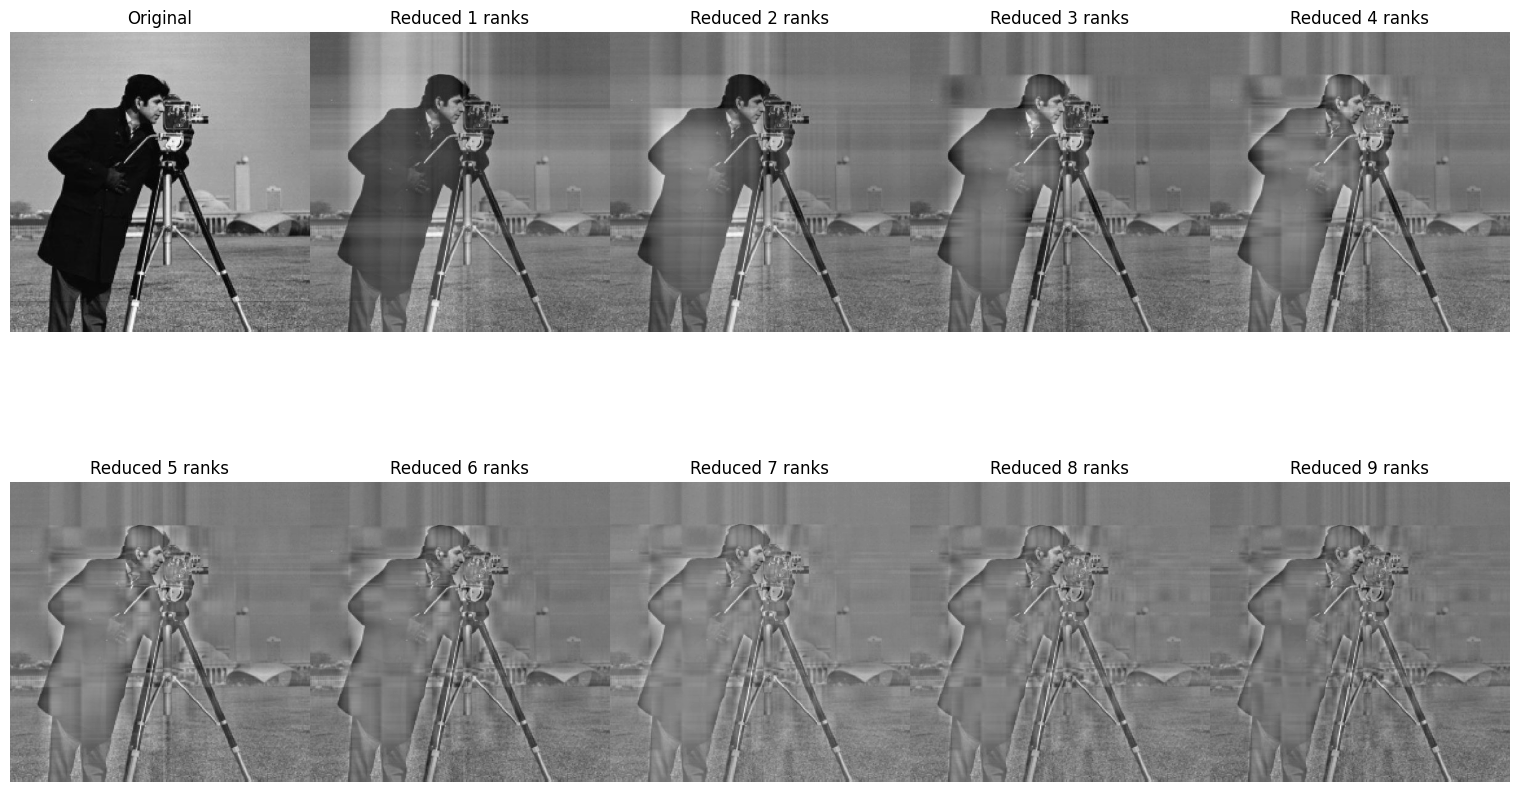

In [304]:
import cv2
import copy
original_img = cv2.imread("./cameraman.jpg", cv2.IMREAD_UNCHANGED)
original_img = original_img.astype(np.float32) # for precision change
num = 8 

# compression and restore
def compress(Sigma, rank=0):
  ########################################
  #------To Do : Fill here---------------#
  ########################################
  if rank ==0:
    return np.diag(Sigma)
  Sigma = Sigma[rank:] # drop the largest sigma
  Sigma = np.diag(Sigma) # make 1D array to 2D matrix for convenience
  ########################################
  #------End of your Code----------------#
  ########################################
  return Sigma

U, Sig, Vt = None, None, None
img_list = [] # list of images in numpy format
########################################
#------To Do : Fill here---------------#
########################################
U,Sig,Vt = SVD(original_img)

# U,Sig,Vt = np.linalg.svd(original_img)
h,w = original_img.shape # get the dimension of original image.
img_list.append(original_img) # we want to show the original image

for rank in range(1,10):
   reduced_sig = compress(Sig,rank)
   reduced_U = U[:,rank:]
   reduced_V = Vt[rank:,:]
   tmpImg = reduced_U.dot(reduced_sig).dot(reduced_V)
   img_list.append(tmpImg)
   
########################################
#------End of your Code----------------#
########################################

# Restore with different ranks(with different a)
gridspec_kw = {"wspace": 0.0, "hspace": 0.0}
fig, ax = plt.subplots(2, 5, gridspec_kw=gridspec_kw, figsize=(15, 9))
fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
for y in range(2):
    for x in range(5):
        idx = 5*y+x
          # original_img
        if idx == 0:
          ax[y][x].set_title("Original")
        else:
          ax[y][x].set_title("Reduced {} ranks".format(idx))
        ax[y][x].imshow(img_list[idx], cmap='gray')
        ax[y][x].set_axis_off()